In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, accuracy_score
import xgboost as xgb
import lightgbm as lgb
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore")

# Load Dataset

In [3]:
df = pd.read_csv("retail_sales_dataset.csv")

In [4]:
df['Date'] = pd.to_datetime(df['Date'])

# Check Duplicate Valuess

In [6]:
df = df.drop_duplicates()

# Check Missing Values

In [8]:
print("Missing values:\n", df.isnull().sum())

Missing values:
 Transaction ID      0
Date                0
Customer ID         0
Gender              0
Age                 0
Product Category    0
Quantity            0
Price per Unit      0
Total Amount        0
dtype: int64


In [9]:
print(df.head())

   Transaction ID       Date Customer ID  Gender  Age Product Category  \
0               1 2023-11-24     CUST001    Male   34           Beauty   
1               2 2023-02-27     CUST002  Female   26         Clothing   
2               3 2023-01-13     CUST003    Male   50      Electronics   
3               4 2023-05-21     CUST004    Male   37         Clothing   
4               5 2023-05-06     CUST005    Male   30           Beauty   

   Quantity  Price per Unit  Total Amount  
0         3              50           150  
1         2             500          1000  
2         1              30            30  
3         1             500           500  
4         2              50           100  


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Transaction ID    1000 non-null   int64         
 1   Date              1000 non-null   datetime64[ns]
 2   Customer ID       1000 non-null   object        
 3   Gender            1000 non-null   object        
 4   Age               1000 non-null   int64         
 5   Product Category  1000 non-null   object        
 6   Quantity          1000 non-null   int64         
 7   Price per Unit    1000 non-null   int64         
 8   Total Amount      1000 non-null   int64         
dtypes: datetime64[ns](1), int64(5), object(3)
memory usage: 70.4+ KB


In [11]:
df.shape

(1000, 9)

In [12]:
df.describe()

,Transaction ID,Date,Age,Quantity,Price per Unit,Total Amount
count,1000.000000,1000,1000.00000,1000.000000,1000.000000,1000.000000
mean,500.500000,2023-07-03 00:25:55.200000256,41.39200,2.514000,179.890000,456.000000
min,1.000000,2023-01-01 00:00:00,18.00000,1.000000,25.000000,25.000000
25%,250.750000,2023-04-08 00:00:00,29.00000,1.000000,30.000000,60.000000
50%,500.500000,2023-06-29 12:00:00,42.00000,3.000000,50.000000,135.000000
75%,750.250000,2023-10-04 00:00:00,53.00000,4.000000,300.000000,900.000000
max,1000.000000,2024-01-01 00:00:00,64.00000,4.000000,500.000000,2000.000000
std,288.819436,NaN,13.68143,1.132734,189.681356,559.997632


# Monthly Trend Analysis

In [14]:
df['Month'] = df['Date'].dt.to_period('M')

In [15]:
#total revenue per customer
revenue_per_customer = df.groupby('Customer ID')['Total Amount'].sum().reset_index(name='Total Revenue')

# Purchase frequency per customer
customer_frequency = df.groupby('Customer ID').size().reset_index(name='Purchase Count')

# Merge both to form a customer summary table
customer_summary = pd.merge(revenue_per_customer, customer_frequency, on='Customer ID')

print(customer_summary.head())

  Customer ID  Total Revenue  Purchase Count
0     CUST001            150               1
1     CUST002           1000               1
2     CUST003             30               1
3     CUST004            500               1
4     CUST005            100               1


# EDA (Explanatory Data Analysis)

# Top-performing product categories

In [18]:
sns.set(style="whitegrid")
top_products = df.groupby('Product Category')['Total Amount'].sum().sort_values(ascending=False)

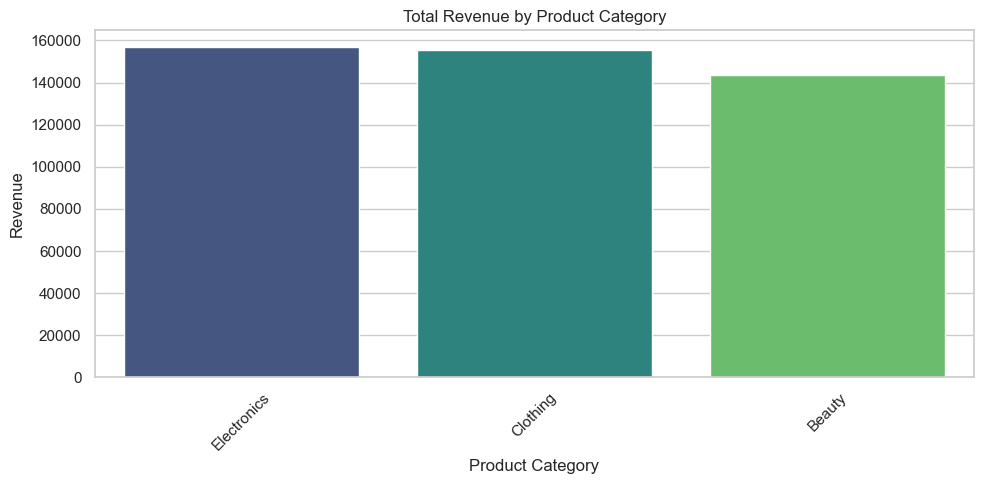

In [19]:
plt.figure(figsize=(10, 5))
sns.barplot(x=top_products.index, y=top_products.values, palette="viridis")
plt.title("Total Revenue by Product Category")
plt.ylabel("Revenue")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Monthly sales trend

In [21]:
monthly_sales = df.groupby('Month')['Total Amount'].sum()

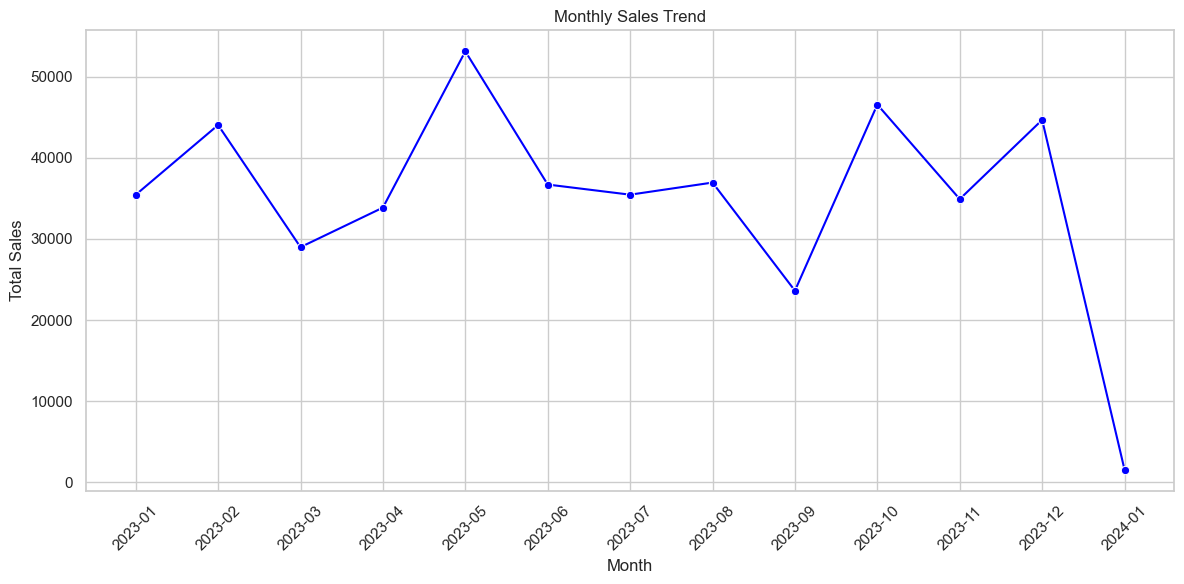

In [22]:
plt.figure(figsize=(12, 6))
monthly_sales.index = monthly_sales.index.astype(str)  # Convert Period to string
sns.lineplot(x=monthly_sales.index, y=monthly_sales.values, marker="o", color="blue")
plt.title("Monthly Sales Trend")
plt.xlabel("Month")
plt.ylabel("Total Sales")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [23]:
# Convert Month to datetime for time series plotting
df['Month'] = df['Date'].dt.to_period('M').dt.to_timestamp()

# Group by month and calculate total sales
monthly_sales = df.groupby('Month')['Total Amount'].sum().reset_index()

# Add 3-month rolling average for trend detection
monthly_sales['Rolling Avg'] = monthly_sales['Total Amount'].rolling(window=3).mean()


# Sales Trend with Rolling Average

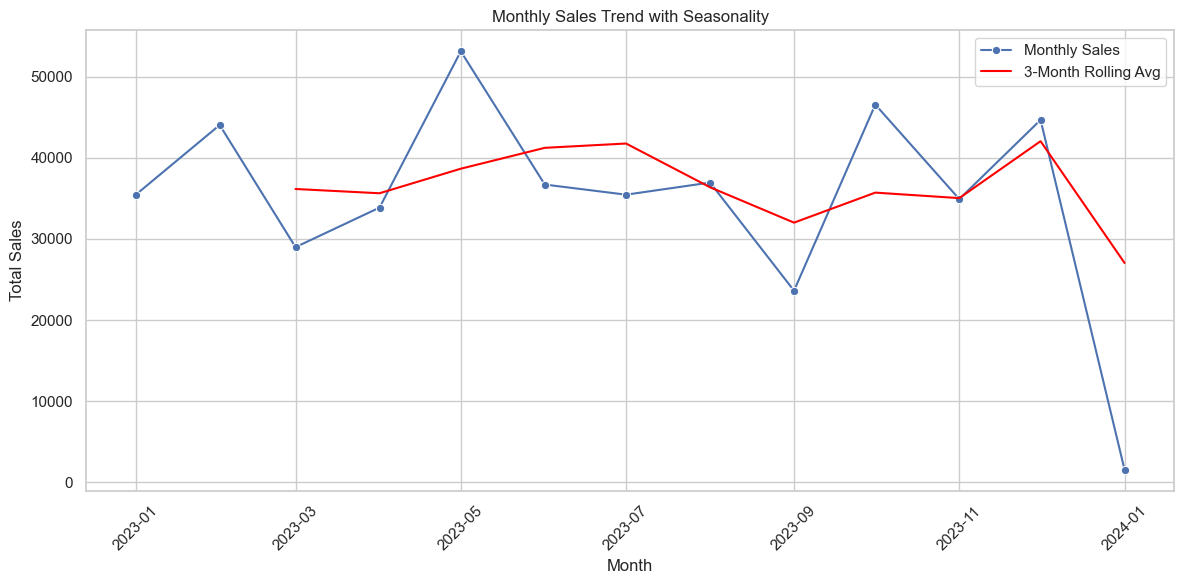

In [25]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_sales, x='Month', y='Total Amount', marker='o', label='Monthly Sales')
sns.lineplot(data=monthly_sales, x='Month', y='Rolling Avg', color='red', label='3-Month Rolling Avg')
plt.title("Monthly Sales Trend with Seasonality")
plt.xlabel("Month")
plt.ylabel("Total Sales")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


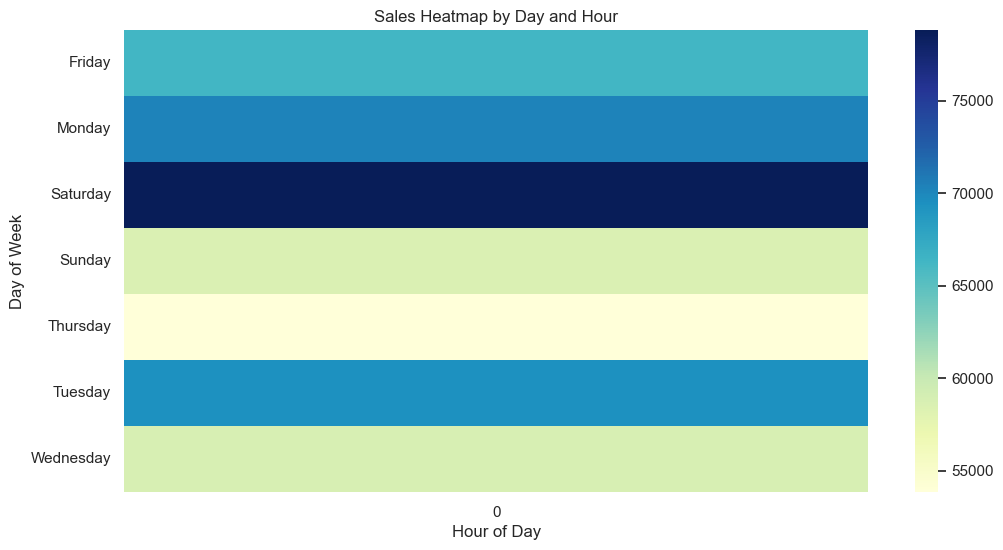

In [26]:
df['Day'] = df['Date'].dt.day_name()
df['Hour'] = df['Date'].dt.hour
heatmap_data = df.groupby(['Day', 'Hour'])['Total Amount'].sum().unstack()

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap="YlGnBu")
plt.title("Sales Heatmap by Day and Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.show()

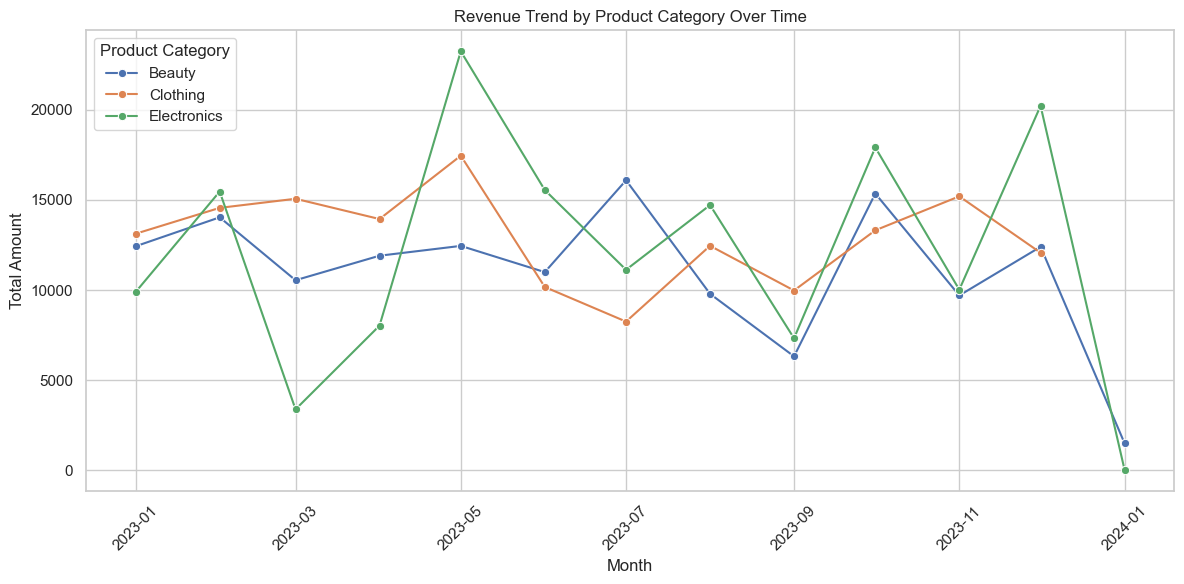

In [27]:
product_trend = df.groupby(['Month', 'Product Category'])['Total Amount'].sum().reset_index()
plt.figure(figsize=(12, 6))
sns.lineplot(data=product_trend, x='Month', y='Total Amount', hue='Product Category', marker="o")
plt.title("Revenue Trend by Product Category Over Time")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

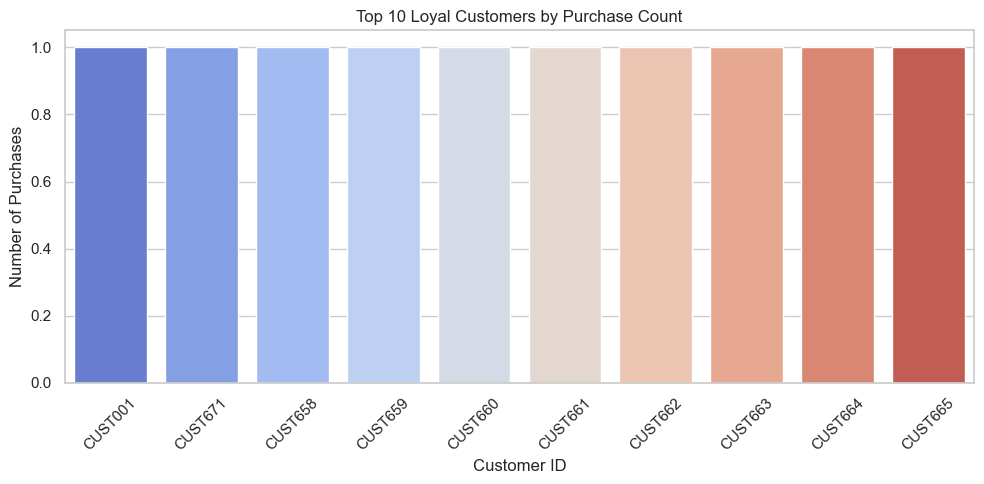

In [28]:
top_customers = customer_summary.sort_values(by='Purchase Count', ascending=False).head(10)
plt.figure(figsize=(10, 5))
sns.barplot(x='Customer ID', y='Purchase Count', data=top_customers, palette='coolwarm')
plt.title("Top 10 Loyal Customers by Purchase Count")
plt.ylabel("Number of Purchases")
plt.xlabel("Customer ID")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Box Plot - To find the Outlier Detection

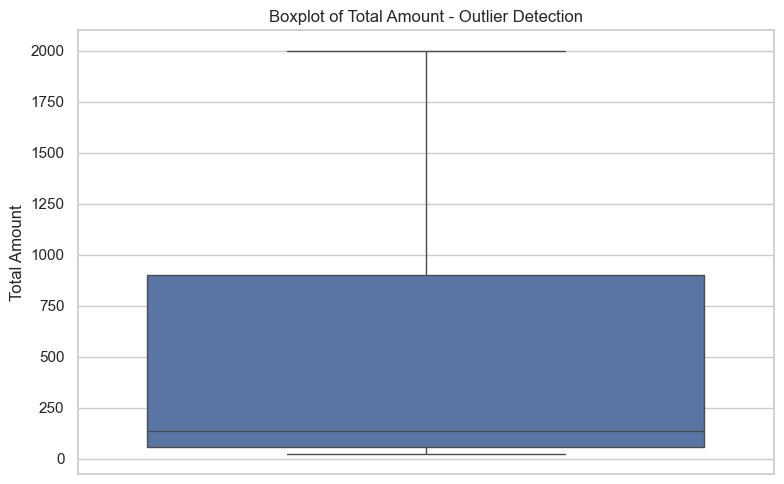

In [30]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, y='Total Amount')
plt.title("Boxplot of Total Amount - Outlier Detection")
plt.tight_layout()
plt.show()

# Feature Engineering

In [32]:
def revenue_segment(x):
    if x >= 1000:
        return 'High'
    elif x >= 500:
        return 'Medium'
    else:
        return 'Low'

def frequency_segment(x):
    if x >= 10:
        return 'Frequent'
    elif x >= 5:
        return 'Occasional'
    else:
        return 'Rare'

In [33]:
 #Apply segmentation
customer_summary['Revenue Segment'] = customer_summary['Total Revenue'].apply(revenue_segment)
customer_summary['Frequency Segment'] = customer_summary['Purchase Count'].apply(frequency_segment)

# Create a combined segment
customer_summary['Customer Segment'] = customer_summary['Revenue Segment'] + ' & ' + customer_summary['Frequency Segment']

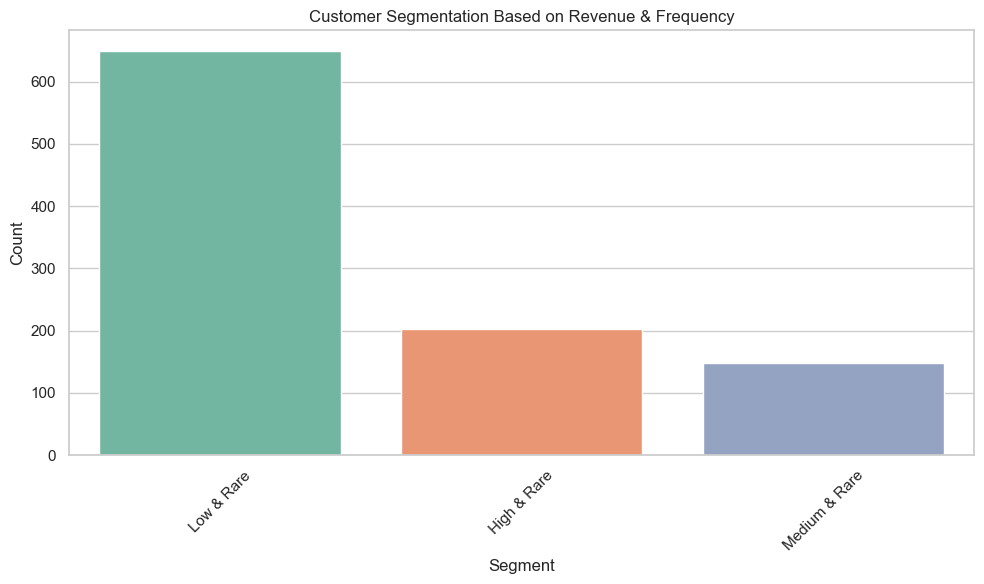

In [34]:
segment_counts = customer_summary['Customer Segment'].value_counts().reset_index()
segment_counts.columns = ['Segment', 'Count']

plt.figure(figsize=(10, 6))
sns.barplot(data=segment_counts, x='Segment', y='Count', palette='Set2')
plt.title("Customer Segmentation Based on Revenue & Frequency")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [35]:
if 'Average Purchase Value' not in customer_summary.columns:
    customer_summary['Average Purchase Value'] = customer_summary['Total Revenue'] / customer_summary['Purchase Count']

In [36]:
clustering_data = customer_summary[['Total Revenue', 'Purchase Count', 'Average Purchase Value']]

# Standardization

In [38]:
# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(clustering_data)

In [39]:
kmeans = KMeans(n_clusters=3, random_state=42)
customer_summary['Cluster'] = kmeans.fit_predict(scaled_data)

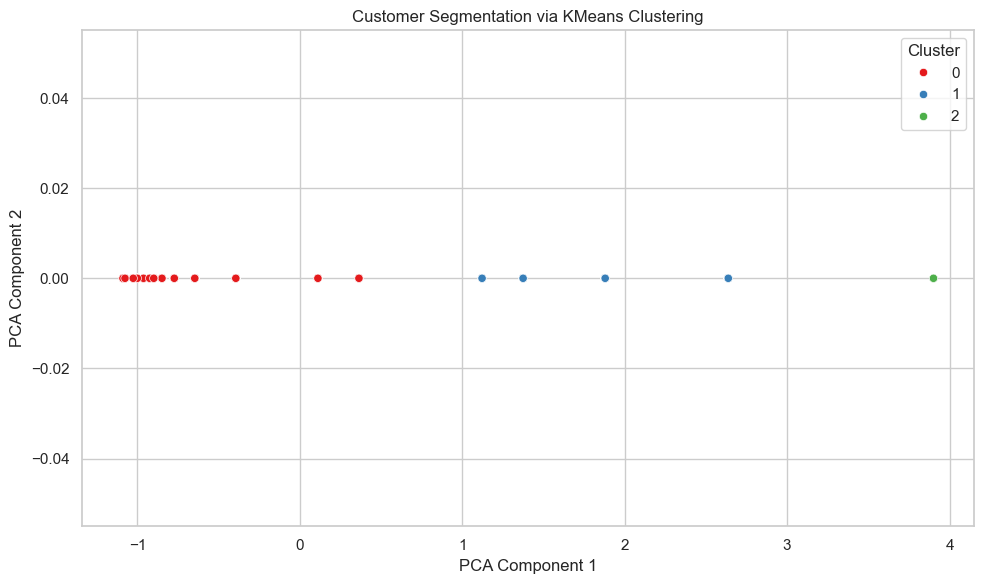

In [40]:
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_data)
customer_summary['PCA1'] = pca_components[:, 0]
customer_summary['PCA2'] = pca_components[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=customer_summary, x='PCA1', y='PCA2', hue='Cluster', palette='Set1')
plt.title('Customer Segmentation via KMeans Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

# Model Training

In [42]:
# Split data for machine learning model
X = customer_summary[['Total Revenue', 'Purchase Count', 'Average Purchase Value']]  # Features
y = customer_summary['Total Revenue']  # Target variable

In [43]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost Model
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.3, learning_rate=0.1,
                          max_depth=5, alpha=10, n_estimators=100)
xg_reg.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xg_reg.predict(X_test)

In [44]:
# LightGBM Model
lgb_reg = lgb.LGBMRegressor()
lgb_reg.fit(X_train, y_train)

# Make predictions
y_pred_lgb = lgb_reg.predict(X_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 38
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 2
[LightGBM] [Info] Start training from score 459.693750
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

# Model Evaluation

In [46]:
y_pred_xgb = xg_reg.predict(X_test)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f"XGBoost Model\nMean Squared Error: {mse_xgb}\nR² Score: {r2_xgb}")

y_pred_lgb = lgb_reg.predict(X_test)
mse_lgb = mean_squared_error(y_test, y_pred_lgb)
r2_lgb = r2_score(y_test, y_pred_lgb)
print(f"LightGBM Model\nMean Squared Error: {mse_lgb}\nR² Score: {r2_lgb}")

XGBoost Model
Mean Squared Error: 0.1319032210946898
R² Score: 0.999999463558197
LightGBM Model
Mean Squared Error: 0.0001831942774596398
R² Score: 0.9999999992935641


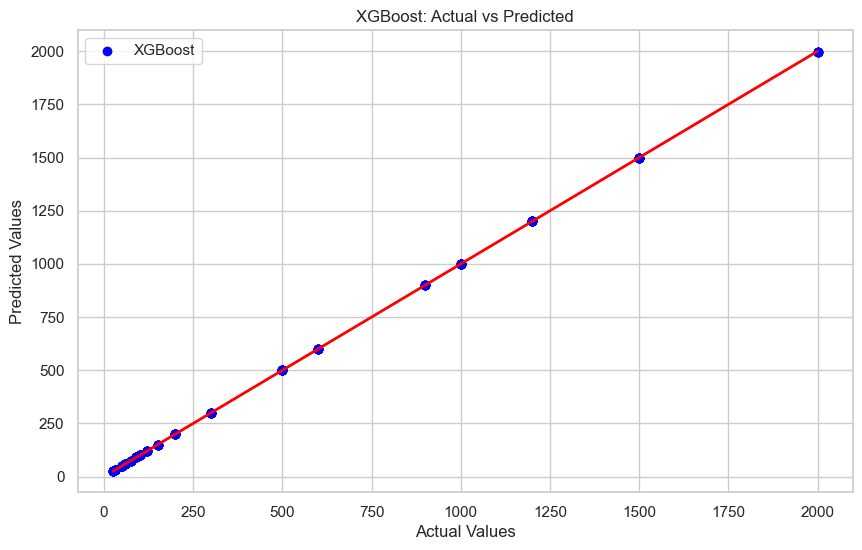

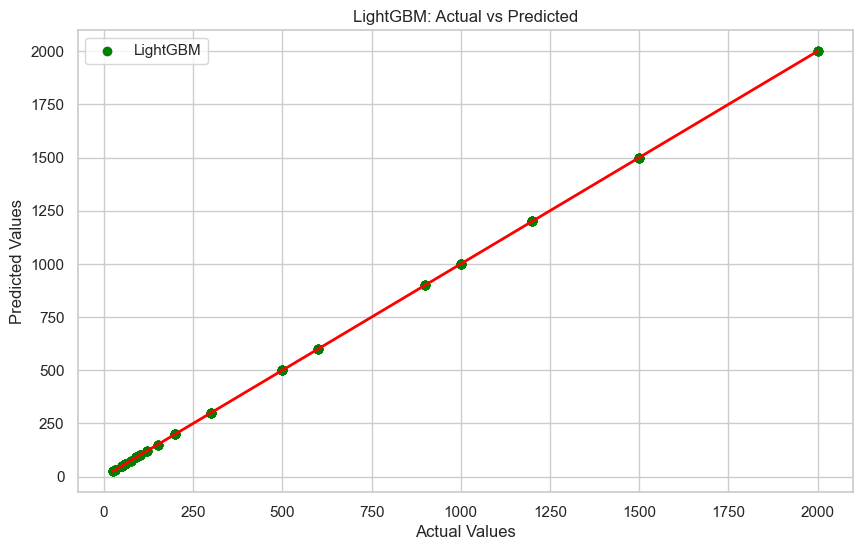

In [47]:
# XGBoost plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_xgb, color='blue', label="XGBoost")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2)
plt.title('XGBoost: Actual vs Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

# LightGBM plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_lgb, color='green', label="LightGBM")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2)
plt.title('LightGBM: Actual vs Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

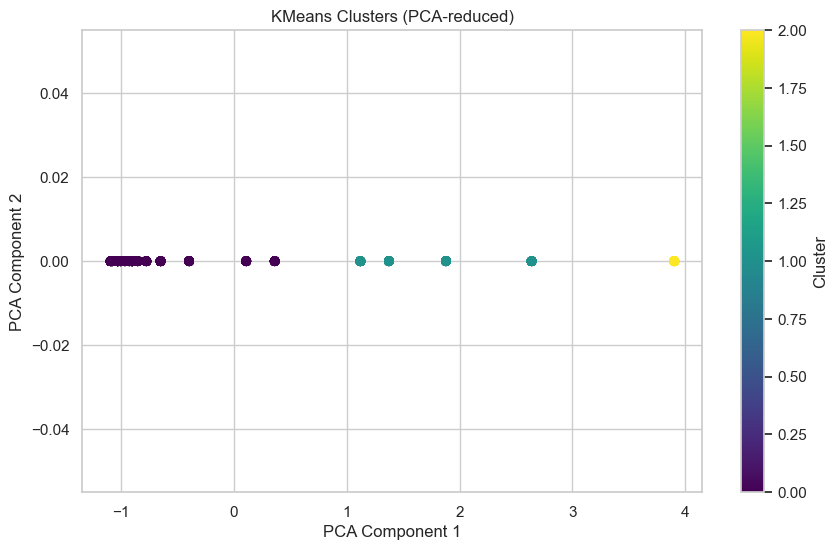

In [48]:
# Visualize PCA components for KMeans clusters
plt.figure(figsize=(10, 6))
plt.scatter(customer_summary['PCA1'], customer_summary['PCA2'], c=customer_summary['Cluster'], cmap='viridis')
plt.title('KMeans Clusters (PCA-reduced)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()
